In [1]:
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt
import numpy as np

X,y = load_digits(return_X_y = True)

(-0.5, 79.5, 79.5, -0.5)

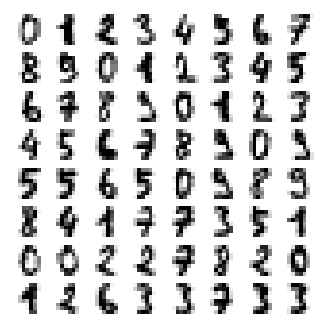

In [3]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))

# Create an empty image with 8 squares
n_img_per_row = 8
img = np.zeros((10 * n_img_per_row, 10 * n_img_per_row))

# Draw the squares
for i in range(n_img_per_row):
    ix = 10 * i + 1
    for j in range(n_img_per_row):
        iy = 10 * j + 1
        img[ix:ix + 8, iy:iy + 8] = X[i*n_img_per_row + j].reshape((8,8))

# Display the image
ax.imshow(img, cmap=plt.cm.binary)
ax.set_xticks([])
ax.set_yticks([])
ax.axis('off')


<bound method Figure.tight_layout of <Figure size 1500x1500 with 1 Axes>>

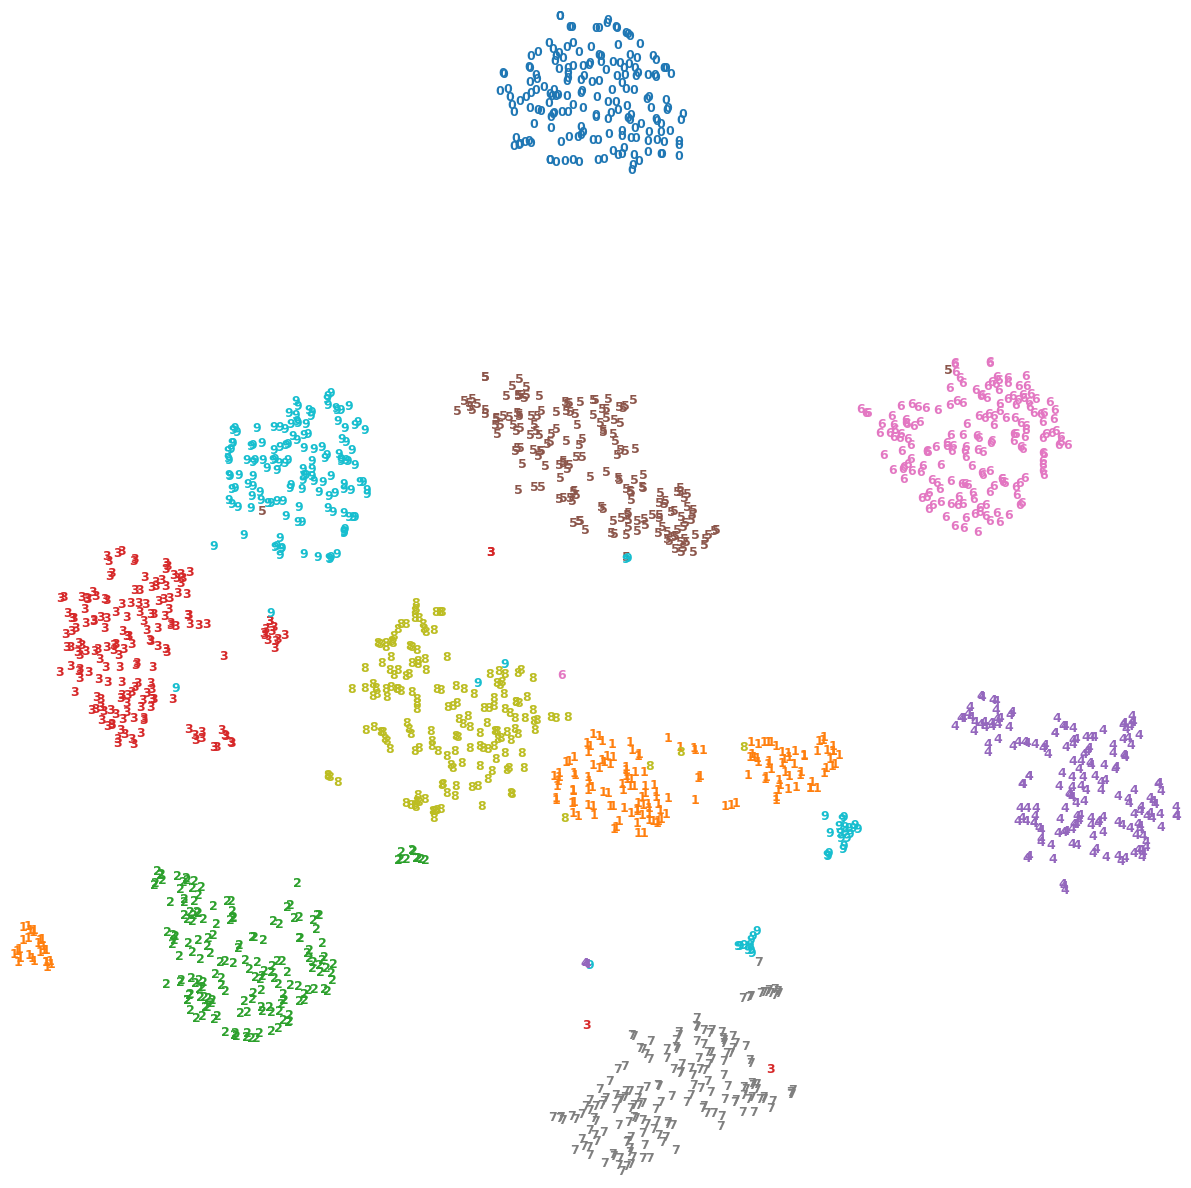

In [6]:
from sklearn.manifold import TSNE
Xemb = TSNE(n_components=2).fit_transform(X)

%matplotlib inline

fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (15,15))
xMin, xMax = np.min(Xemb, axis=0), np.max(Xemb, axis=0)
Xemb = (Xemb - xMin) / (xMax - xMin)
for i in range(Xemb.shape[0]):
  plt.text(Xemb[i,0], Xemb[i,1], str(y[i]), color=plt.cm.tab10(y[i] / 10.), fontdict ={'weight': 'bold', 'size': 9})

ax.set_xticks([])
ax.set_yticks([])
ax.axis('off')
fig.tight_layout


In [7]:
from sklearn.model_selection import train_test_split
Xtrn, Xtst, ytrn, ytst = train_test_split(Xemb, y, test_size = 0.2, stratify =y)

In [11]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

# Create a decision stump
stump = DecisionTreeClassifier(max_depth=1)

# Create an AdaBoost ensemble with 100 decision stumps
ensemble = AdaBoostClassifier(base_estimator=stump)


In [12]:
parameters_to_search = {'n_estimators' : [200, 300, 400],
                        'learning_rate': [0.6, 0.8, 1.0]}

In [14]:
#Scoring function
from sklearn.metrics import balanced_accuracy_score, make_scorer
scorer = make_scorer(balanced_accuracy_score, greater_is_better=True)

#gridsearch modelling
from sklearn.model_selection import GridSearchCV
search = GridSearchCV(ensemble, param_grid=parameters_to_search,
scoring=scorer, cv=5, n_jobs=1, refit=True) #5-fold cross validation
search.fit(Xtrn, ytrn)


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/en

GridSearchCV(cv=5,
             estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1)),
             n_jobs=1,
             param_grid={'learning_rate': [0.6, 0.8, 1.0],
                         'n_estimators': [200, 300, 400]},
             scoring=make_scorer(balanced_accuracy_score))

In [15]:
#best parameter setting
best_combo = search.cv_results_['params'][search.best_index_]
best_score = search.best_score_
print('Thes best parameter settings are {0}, with score = {1}.' .format(best_combo, best_score))

#The best model is available in search.best_estimator_ and can be used for making predictions on the test data.
ypred = search.best_estimator_.predict(Xtst)

from sklearn.metrics import confusion_matrix
print("Confusion matrix: \n {0}".format(confusion_matrix(ytst, ypred)))

Thes best parameter settings are {'learning_rate': 0.8, 'n_estimators': 200}, with score = 0.7009173508483854.
Confusion matrix: 
 [[36  0  0  0  0  0  0  0  0  0]
 [ 0 33  0  0  0  0  0  0  2  1]
 [ 0 15  0 19  0  0  0  0  0  1]
 [ 0  8  0 29  0  0  0  0  0  0]
 [ 0  0  0  0 35  0  0  0  0  1]
 [ 0  0  0  1  0 36  0  0  0  0]
 [ 0  0  0  0  0 14 22  0  0  0]
 [ 0  0  0  0  0  0  0 36  0  0]
 [ 0 10  0  5  0  0  0  0 20  0]
 [ 0  5  0 29  0  0  0  0  1  1]]


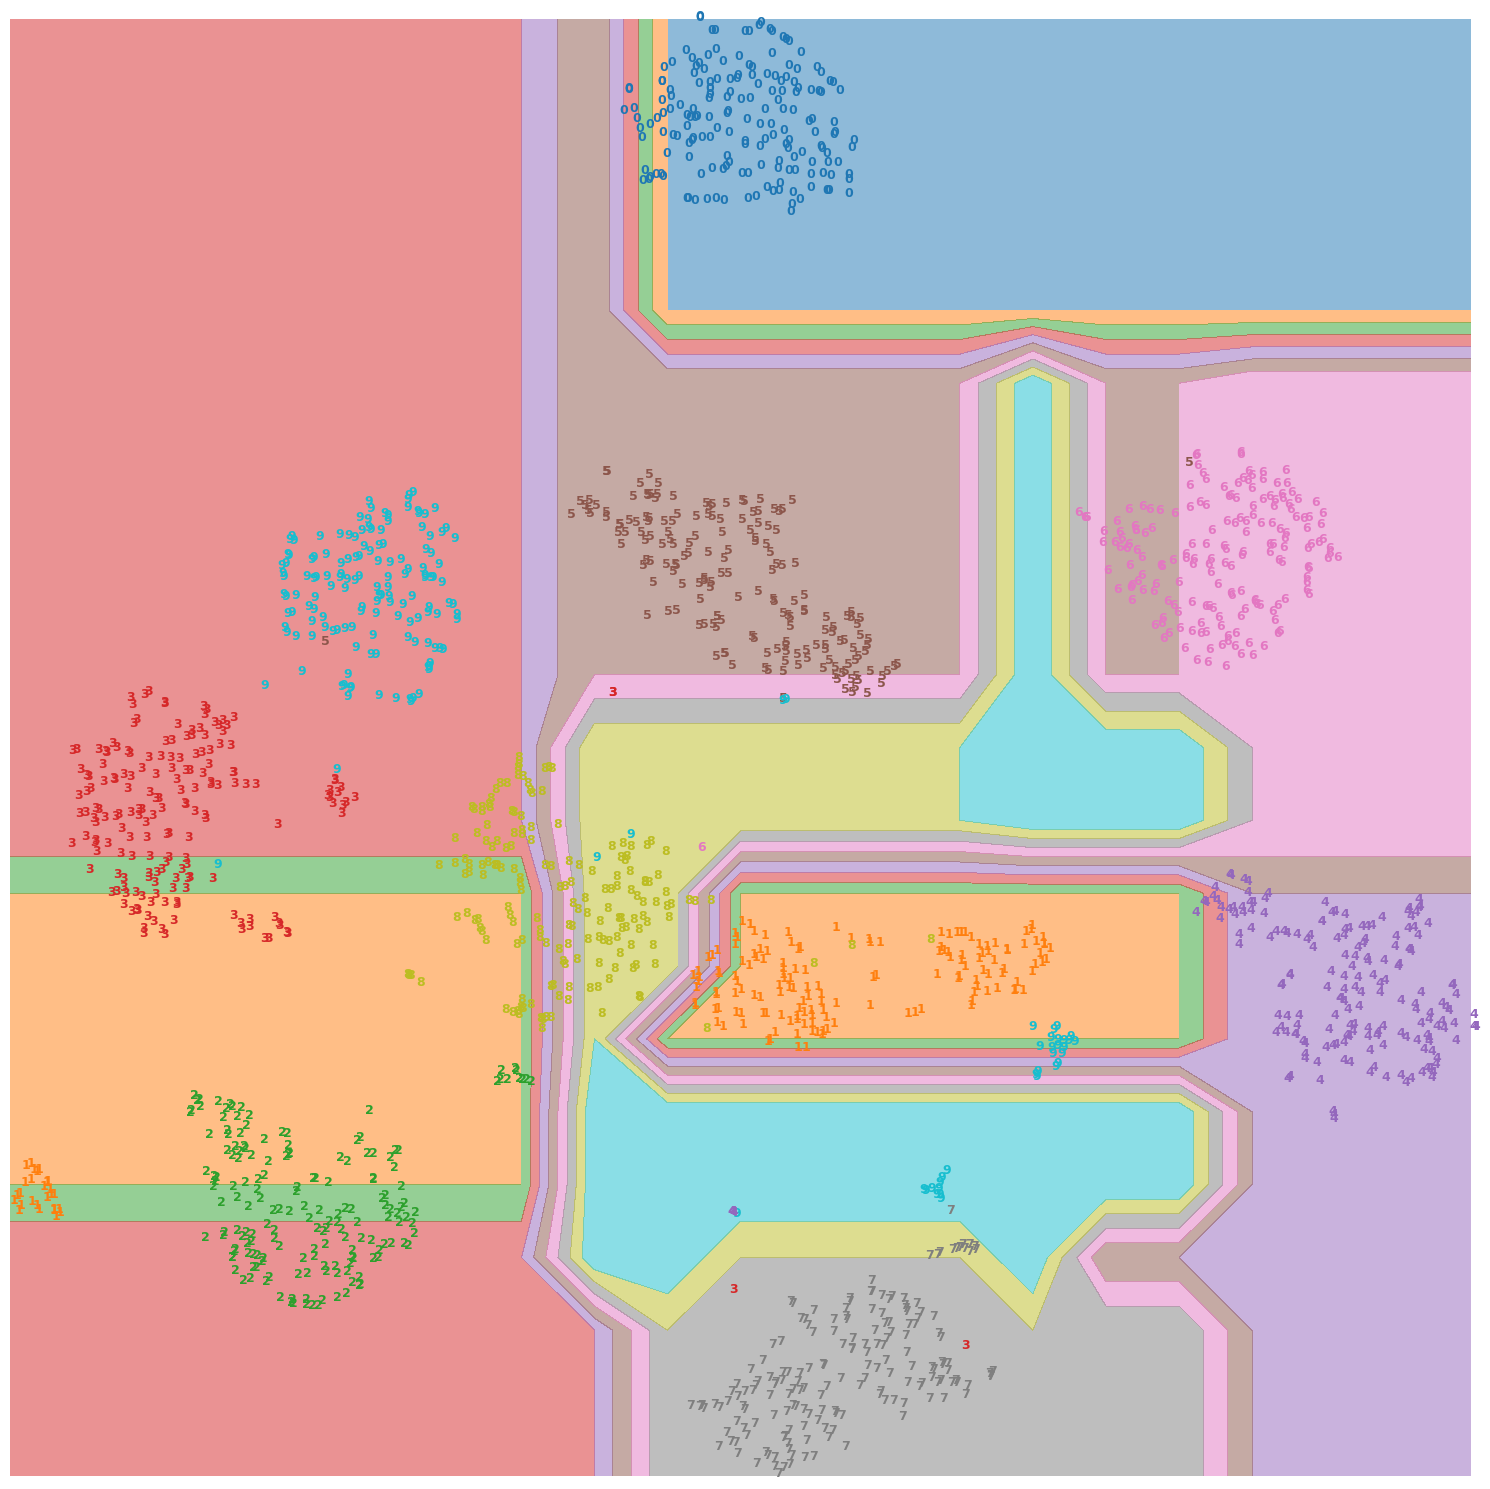

In [16]:
#Visualize the decision boundary
xMin, xMax = Xemb[:, 0].min(), Xemb[:, 0].max() + 0.05
yMin, yMax = Xemb[:, 1].min(), Xemb[:, 1].max() + 0.05

xMesh, yMesh = np.meshgrid(
    np.arange(xMin, xMax, 0.05),
    np.arange(yMin, yMax, 0.05),
)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))

zMesh = search.best_estimator_.predict(np.c_[xMesh.ravel(), yMesh.ravel()])
zMesh = zMesh.reshape(xMesh.shape) * 1.0

boundary = ax.contourf(
    xMesh, yMesh, zMesh, np.array([-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
    cmap=plt.cm.tab10,
    alpha=0.5,
)

for i in range(X.shape[0]):
    plt.text(
        Xemb[i, 0],
        Xemb[i, 1],
        str(y[i]),
        color=plt.cm.tab10(y[i] / 10.),
        fontdict={"weight": "bold", "size": 9},
    )

ax.axis("off")
# fig.colorbar(boundary)
fig.tight_layout()
